<a href="https://colab.research.google.com/github/jujhaar2409/unClear/blob/master/assignments/sketch_colorizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sketch-colorizer

A CGAN based model which takes in a sketch image and colorizes it.
The dataset used is available on [kaggle](https://www.kaggle.com/ktaebum/anime-sketch-colorization-pair)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# drive.mount('/content/drive', force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import files
files.upload() 
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [3]:
!cd ~/.kaggle && pwd && ls

/root/.kaggle
kaggle.json


In [4]:
# !kaggle datasets download --force -d ktaebum/anime-sketch-colorization-pair -p /content/drive/Shareddrives/main/kaggle
!kaggle datasets download --force -d ktaebum/anime-sketch-colorization-pair

100% 11.6G/11.6G [04:52<00:00, 48.7MB/s]
100% 11.6G/11.6G [04:52<00:00, 42.7MB/s]


In [5]:
# !unzip "/content/drive/Shareddrives/main/kaggle/colorizer-anime/anime-sketch-colorization-pair.zip" -d "/content/drive/Shareddrives/main/kaggle/colorizer-anime/unzipped/"
!unzip "/content/anime-sketch-colorization-pair.zip"

Streaming output truncated to the last 5000 lines.
  inflating: data/train/2906115.png  
  inflating: data/train/2906116.png  
  inflating: data/train/2906119.png  
  inflating: data/train/2906139.png  
  inflating: data/train/2906140.png  
  inflating: data/train/2906141.png  
  inflating: data/train/2906143.png  
  inflating: data/train/2907043.png  
  inflating: data/train/2907052.png  
  inflating: data/train/2907059.png  
  inflating: data/train/2907062.png  
  inflating: data/train/2907075.png  
  inflating: data/train/2907105.png  
  inflating: data/train/2907107.png  
  inflating: data/train/2907108.png  
  inflating: data/train/2907113.png  
  inflating: data/train/2907130.png  
  inflating: data/train/2907138.png  
  inflating: data/train/2907144.png  
  inflating: data/train/2907146.png  
  inflating: data/train/2907148.png  
  inflating: data/train/2907149.png  
  inflating: data/train/2908002.png  
  inflating: data/train/2908023.png  
  inflating: data/train/2908039.png  

In [1]:
import tensorflow as tf
import os
import time
from matplotlib import pyplot as plt

In [27]:
PATH ='/content/data'
EPOCHS = 5
BUFFER_SIZE = 14224 // 10
BATCH_SIZE = 4
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [28]:
def load(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_image(image,expand_animations = False)
    w = tf.shape(image)[1]
    w = w//2
    real_image = image[:,:w,:]
    input_image = image[:,w:,:]
    real_image = tf.cast(real_image,tf.float32)
    input_image = tf.cast(input_image,tf.float32)
    return input_image,real_image

def normalize(input_image, real_image):
    input_image = input_image/127.5 -1
    real_image = real_image/127.5 -1
    return input_image, real_image

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image,real_image):
    stack = tf.stack([input_image,real_image],axis=0)
    cropped = tf.image.random_crop(stack, size=[2,256,256,3])
    return cropped[0],cropped[1]

@tf.function()
def random_jitter(input_image, real_image):
    input_image, real_image = resize(input_image,real_image,286,286)
    input_image, real_image = random_crop(input_image,real_image)
    
    if tf.random.uniform(())>0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
        
    return input_image, real_image

In [29]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

def load_image_test(file_path):
    input_image, real_image = load(file_path)
    input_image, real_image = resize(input_image, real_image,256,256)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

In [30]:
train_dataset = tf.data.Dataset.list_files(PATH+'/train/*.png')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files(PATH+"/val/*.png")
test_dataset = test_dataset.map(load_image_test,num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [31]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, shape, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', batch_input_shape=shape, 
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, size, shape, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2, batch_input_shape=shape,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

def buildGenerator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, (None, 256, 256, 3), apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4, (None, 128, 128, 64)), # (bs, 64, 64, 128)
        downsample(256, 4, (None, 64, 64, 128)), # (bs, 32, 32, 256)
        downsample(512, 4, (None, 32, 32, 256)), # (bs, 16, 16, 512)
        downsample(512, 4, (None, 16, 16, 512)), # (bs, 8, 8, 512)
        downsample(512, 4, (None, 8, 8, 512)), # (bs, 4, 4, 512)
        downsample(512, 4, (None, 4, 4, 512)), # (bs, 2, 2, 512)
        downsample(512, 4, (None, 2, 2, 512)), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, (None, 1, 1, 512), apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, (None, 2, 2, 1024), apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, (None, 4, 4, 1024), apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4, (None, 8, 8, 1024)), # (bs, 16, 16, 1024)
        upsample(256, 4, (None, 16, 16, 1024)), # (bs, 32, 32, 512)
        upsample(128, 4, (None, 32, 32, 512)), # (bs, 64, 64, 256)
        upsample(64, 4, (None, 64, 64, 256)), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [32]:
generator = buildGenerator()

In [33]:
def downs(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', 
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def buildDiscriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downs(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downs(128, 4)(down1) # (bs, 64, 64, 128)
    # down3 = downs(256, 4)(down2) # (bs, 32, 32, 256)

    # zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [34]:
discriminator = buildDiscriminator()
discriminator.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_16 (Concatenate)    (None, 256, 256, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_35 (Sequential)      (None, 128, 128, 64) 6144        concatenate_16[0][0]       

In [35]:
loss_object = tf.losses.BinaryCrossentropy(from_logits=True)

LAMBDA = 100

def generator_loss(disc_generated_output,gen_output,target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output),disc_generated_output)
    
    l1_loss = tf.reduce_mean(tf.abs(target-gen_output))
    total_gen_loss = gan_loss +(LAMBDA*l1_loss)
    
    return total_gen_loss,gan_loss,l1_loss

def discriminator_loss(disc_real_output,disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output),disc_real_output)
    
    generated_loss = loss_object(tf.zeros_like(disc_generated_output),disc_generated_output)
    
    total_disc_loss = generated_loss + real_loss
    return total_disc_loss

In [36]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

In [37]:
checkpoint_dir = '/content/drive/Shareddrives/main/kaggle/colorizer-anime/anime-checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "checkpoint")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,generator=generator,
                                 discriminator=discriminator)

In [38]:
def generate_images(model,test_input,tar):
    prediction = model(test_input,training = True)
    plt.figure(figsize = (15,15))
    
    display_list= [test_input[0],tar[0],prediction[0]]
    title = ['Input image', 'Ground image', 'Predicted image']
    
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]*0.5+0.5)
        plt.axis('off')
    plt.show()

In [39]:
import datetime
log_dir="/content/anime-logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [40]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss',gen_total_loss,step = epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [44]:
def fit(train_ds,epochs,test_ds):
    for epoch in range(epochs):
        start = time.time()
        
        for n,(input_image,target) in train_ds.enumerate():
            if n < 20:
              print(f'{(((time.time() - start) * 10) // 1 )/ 10},',end = '')
            else: 
              print(".", end="")
            if (n+1)%100==0:
                print()
            train_step(input_image,target,epoch)
        print()
        if (epoch+1)%5==0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        for example_input, example_target in test_ds.take(1):
            generate_images(generator,example_input,example_target)
            
        print("Epoch: ",epoch)
        print('Time taken for epoch {} is {} sec\n'.format(epoch+1,time.time()-start))
    checkpoint.save(file_prefix =checkpoint_prefix)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

21.4,22.0,22.4,22.8,23.3,23.7,24.1,24.6,25.0,25.5,25.9,26.3,26.8,27.2,27.7,28.1,28.5,29.0,29.4,29.9,................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........

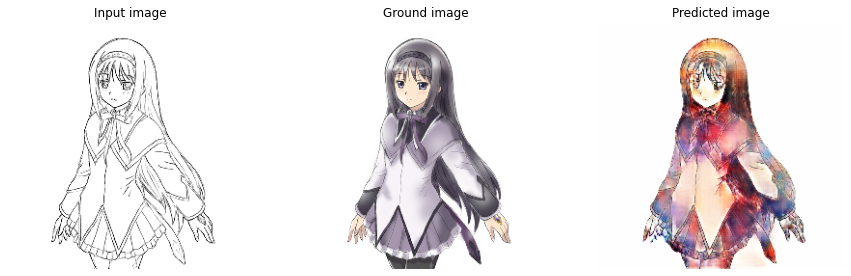

Epoch:  0
Time taken for epoch 1 is 1590.5364773273468 sec

20.8,23.3,23.8,24.2,24.7,25.1,25.5,26.0,26.4,26.9,27.3,27.7,28.2,28.6,29.1,29.5,30.0,30.4,30.8,31.3,................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................

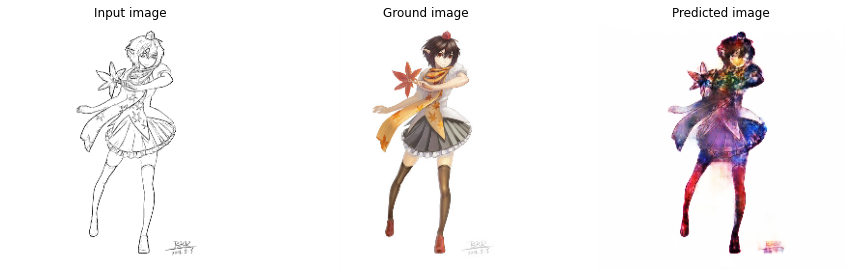

Epoch:  1
Time taken for epoch 2 is 1589.9814159870148 sec

20.6,22.9,23.3,23.8,24.2,24.7,25.1,25.6,26.0,26.4,26.9,27.3,27.8,28.2,28.6,29.1,29.5,30.0,30.4,30.8,................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................

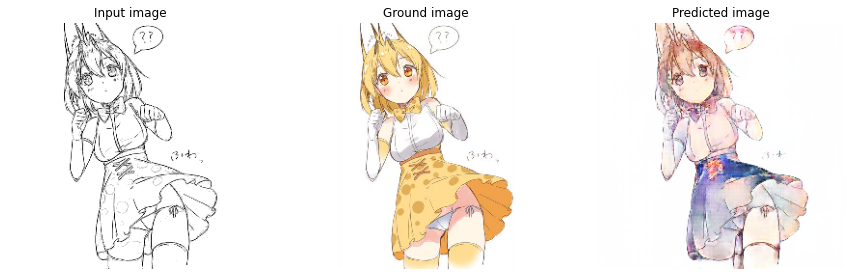

Epoch:  2
Time taken for epoch 3 is 1589.0475668907166 sec

19.8,22.1,22.5,23.0,23.4,23.9,24.3,24.7,25.2,25.6,26.0,26.5,26.9,27.4,27.8,28.2,28.7,29.1,29.5,30.0,................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................

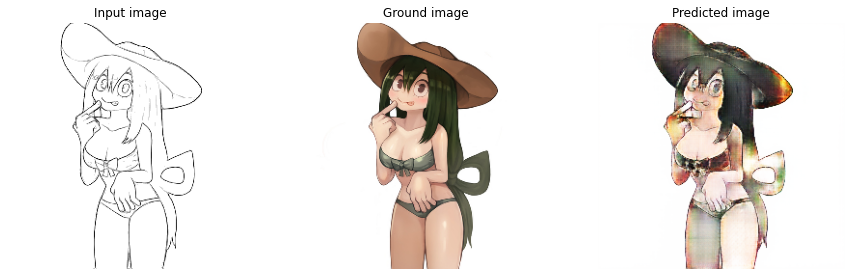

Epoch:  3
Time taken for epoch 4 is 1587.6195139884949 sec

19.9,22.7,23.1,23.6,24.0,24.5,24.9,25.3,25.8,26.2,26.7,27.1,27.6,28.0,28.5,28.9,29.4,29.8,30.2,30.7,................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................

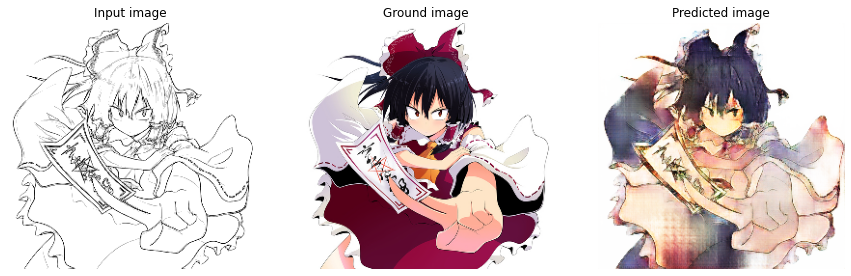

Epoch:  4
Time taken for epoch 5 is 1592.870864391327 sec



In [47]:
checkpoint.save(file_prefix =checkpoint_prefix)

'/content/drive/Shareddrives/main/kaggle/colorizer-anime/anime-checkpoints/checkpoint-3'

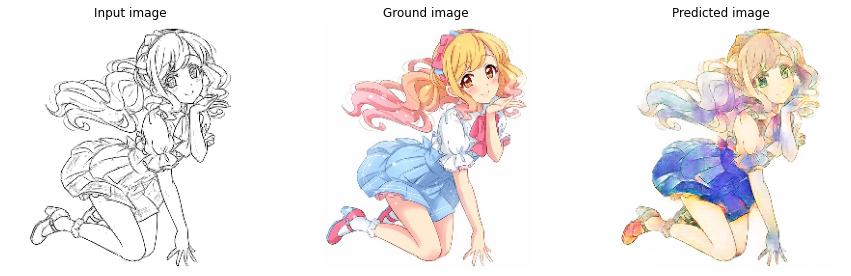

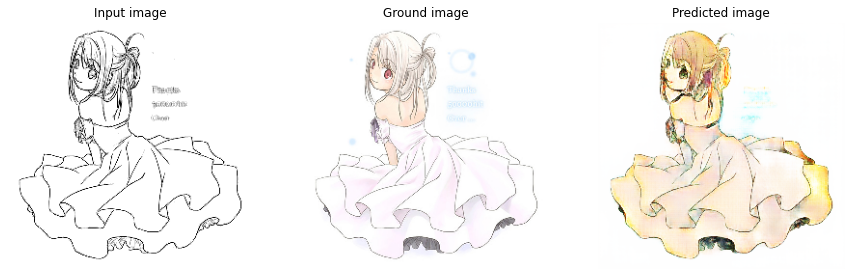

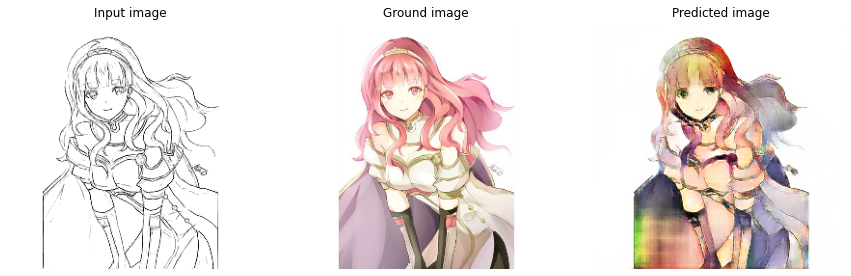

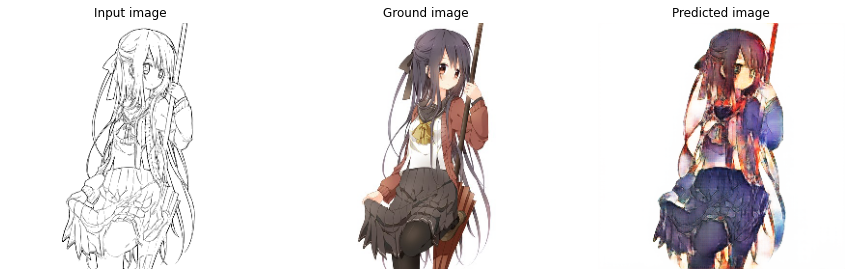

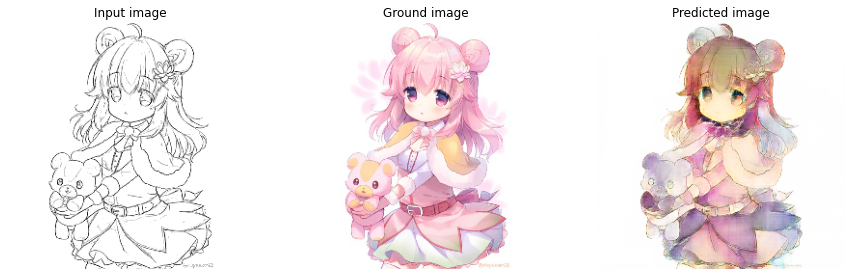

In [52]:
for example_input, example_target in test_dataset.take(5):
    generate_images(generator, example_input, example_target)

In [51]:
generator.save('/content/drive/Shareddrives/main/kaggle/colorizer-anime/AnimeColorizationModelv1.h5')